In [1]:
import warnings

import time

import entwiner
import unweaver
from shapely.geometry import mapping, shape
from sqlite3 import OperationalError

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
G = entwiner.DiGraphDBView(path="../artifacts/unweaver/graph.facilities.gpkg")

In [3]:
# cost_fun = lambda u, v, d: d["length"]

# def cost_fun(u, v, d):
#     if d["incline"] is not None:
#         if (d["incline"] > 0.1) or (d["incline"] < -0.1):
#             return None
#     if d["curbramps"] is not None:
#         if not d["curbramps"]:
#             return None
#     return d.get("length", None)

In [4]:
try:
    with G.network.gpkg.connect() as conn:
        conn.execute("ALTER TABLE edges ADD COLUMN wheelchair_weight DOUBLE")
except OperationalError:
    # The column already exists (probably)
    pass

In [5]:
with G.network.gpkg.connect() as conn:
    conn.execute("""
        UPDATE edges
           SET wheelchair_weight = length
    """)
    conn.execute("""
        UPDATE edges
           SET wheelchair_weight = NULL
         WHERE (incline IS NOT NULL) AND (ABS(incline) > 0.1)
    """)
    conn.execute("""
        UPDATE edges
           SET wheelchair_weight = NULL
         WHERE (curbramps IS NOT NULL) AND (curbramps != 1)
    """)
    


In [6]:
facility_classes = [row["f"] for row in G.network.gpkg.conn.execute("SELECT DISTINCT(facility) f FROM facility_edges")]
facility_classes

['school', 'pharmacy', 'bank', 'bar', 'sports_field', 'park', 'hospital']

In [ ]:
# TODO: this does double the necessary work. Isolate unique (u, v) pairs first (v,u = u,v)?
# edges = G.network.edges
cost_fun = lambda u, v, d: d["_weight_walk"]
if "facility_points" in G.network.gpkg.feature_tables:
    G.network.gpkg.drop_feature_table("facility_points")
facility_points = G.network.gpkg.add_feature_table("facility_points", "Point")

edges = [(e.pop("_u"), e.pop("_v"), e) for e in G.network.edges.intersects(-122.3222, 47.6532, -122.3121, 47.6613)]
edges = G.iter_edges()

start = time.time()

# updates = []
point_features = []

count = 0
failures = 0


for i, (u, v, d) in enumerate(edges):
#     if count > 100:
#         break
    try:
        point = shape(d["geom"]).interpolate(0.5, normalized=True)
    except AttributeError:
        # Encountered bad data - skip
        continue
    except ValueError:
        # Encountered bad data - skip
        continue
    candidates = unweaver.graph.waypoint_candidates(G, point.x, point.y, 1, dwithin=1)
    feature = {"geom": mapping(point)}
    for facility_class in facility_classes:
        feature[facility_class] = 0
        
    try:
        candidate = next(candidates)
        G_aug = unweaver.graphs.augmented.prepare_augmented(G, candidate)
        path, edge_list = unweaver.algorithms.reachable.reachable(G_aug, candidate, cost_fun, 400)
        edge_list = ",".join((str(e["fid"]) for e in edge_list))
        query = G.network.gpkg.conn.execute(f"""
            SELECT COUNT(DISTINCT facility_osm_id) count,
                   facility
              FROM facility_edges 
             WHERE edge_fid IN ({edge_list})
          GROUP BY facility
        """)
        # Keys (facilities) are unique due to group by            
        for row in query:
            feature[row["facility"]] = row["count"]
        point_features.append(feature)
        count += 1
    except StopIteration:
        point_features.append(feature)
        continue
    except Exception as e:
        print(e)
        failures += 1
        pass

print(time.time() - start)
print(failures)

facility_points.write_features(point_features)

In [8]:
# TODO: this does double the necessary work. Isolate unique (u, v) pairs first (v,u = u,v)?
# edges = G.network.edges
cost_fun = lambda u, v, d: d["_weight_wheelchair"]
if "facility_points_wheelchair" in G.network.gpkg.feature_tables:
    G.network.gpkg.drop_feature_table("facility_points_wheelchair")
facility_points = G.network.gpkg.add_feature_table("facility_points_wheelchair", "Point")

edges = [(e.pop("_u"), e.pop("_v"), e) for e in G.network.edges.intersects(-122.3222, 47.6532, -122.3121, 47.6613)]
edges = G.iter_edges()

start = time.time()

# updates = []
point_features = []

count = 0
failures = 0


for i, (u, v, d) in enumerate(edges):
#     if count > 100:
#         break
    try:
        point = shape(d["geom"]).interpolate(0.5, normalized=True)
    except AttributeError:
        # Encountered bad data - skip
        continue
    except ValueError:
        # Encountered bad data - skip
        continue
    candidates = unweaver.graph.waypoint_candidates(G, point.x, point.y, 1, dwithin=1)
    feature = {"geom": mapping(point)}
    for facility_class in facility_classes:
        feature[facility_class] = 0
        
    try:
        candidate = next(candidates)
        G_aug = unweaver.graphs.augmented.prepare_augmented(G, candidate)
        path, edge_list = unweaver.algorithms.reachable.reachable(G_aug, candidate, cost_fun, 400)
        edge_list = ",".join((str(e["fid"]) for e in edge_list))
        query = G.network.gpkg.conn.execute(f"""
            SELECT COUNT(DISTINCT facility_osm_id) count,
                   facility
              FROM facility_edges 
             WHERE edge_fid IN ({edge_list})
          GROUP BY facility
        """)
        # Keys (facilities) are unique due to group by            
        for row in query:
            feature[row["facility"]] = row["count"]
        point_features.append(feature)
        count += 1
    except StopIteration:
        point_features.append(feature)
        continue
    except Exception as e:
        print(e)
        failures += 1
        pass

print(time.time() - start)
print(failures)

facility_points.write_features(point_features)

In [9]:
import geopandas as gpd
import plotnine as p

fids = [int(e) for e in edge_list.split(",")]
query = G.network.gpkg.conn.execute(f"""
    SELECT *
      FROM edges
     WHERE fid IN ({edge_list})
""")

rows = [G.network.edges.deserialize_row(r) for r in query]
gdf = gpd.GeoDataFrame([{**r, "geometry": shape(r["geom"])} for r in rows])
gdf.crs = 4326
gdf2 = gdf.to_crs(26910)

point = gpd.GeoDataFrame([{"geometry": candidate.geometry}])
point.crs = 4326
point = point.to_crs(26910)

(
    p.ggplot(gdf2)
    + p.geom_map()
    + p.geom_map(data=point, fill="red", size=2)
)

In [7]:
98121 in fids

False

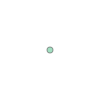

In [8]:
candidate.geometry

In [9]:
        query = G.network.gpkg.conn.execute(f"""
            SELECT COUNT(DISTINCT facility_osm_id) count,
                   facility
              FROM facility_edges 
             WHERE edge_fid IN ({edge_list})
          GROUP BY facility
        """)

In [10]:
edges[0][2]["fid"]

2445

In [11]:
edge2 = [e for e in edges if e[2]["fid"] == 118831][0]
u, v, d = edge2

point = shape(d["geom"]).interpolate(0.5, normalized=True)
candidates = unweaver.graph.waypoint_candidates(G, point.x, point.y, 1, dwithin=1)
candidate = next(candidates)

feature = {"geom": mapping(point)}
for facility_class in facility_classes:
    feature[facility_class] = 0

G_aug = unweaver.augmented.prepare_augmented(G, candidate)
path, edge_list = unweaver.algorithms.reachable.reachable(G_aug, candidate, cost_fun, 400)
edge_list = ",".join((str(e["fid"]) for e in edge_list))
query = G.network.gpkg.conn.execute(f"""
    SELECT COUNT(DISTINCT facility_osm_id) count,
           facility
      FROM facility_edges 
     WHERE edge_fid IN ({edge_list})
  GROUP BY facility
""")
print(list(query))

[{'count': 6, 'facility': 'bank'}, {'count': 3, 'facility': 'bar'}, {'count': 2, 'facility': 'park'}, {'count': 3, 'facility': 'pharmacy'}, {'count': 1, 'facility': 'sports_field'}]


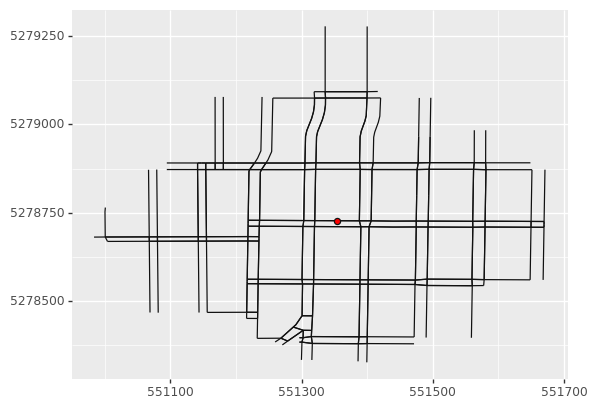

<ggplot: (-9223363243726710903)>

In [12]:
import geopandas as gpd
import plotnine as p

fids = [int(e) for e in edge_list.split(",")]
query = G.network.gpkg.conn.execute(f"""
    SELECT *
      FROM edges
     WHERE fid IN ({edge_list})
""")

rows = [G.network.edges.deserialize_row(r) for r in query]
gdf = gpd.GeoDataFrame([{**r, "geometry": shape(r["geom"])} for r in rows])
gdf.crs = 4326
gdf2 = gdf.to_crs(26910)

ex_point = gpd.GeoDataFrame([{"geometry": shape({"type": "Point", "coordinates": [point.x, point.y]})}])
# point = gpd.GeoDataFrame([{"geometry": candidate.geometry}])
ex_point.crs = 4326
ex_point = ex_point.to_crs(26910)

(
    p.ggplot(gdf2)
    + p.geom_map()
    + p.geom_map(data=ex_point, fill="red", size=2)
)